![CMCC](http://cmcc.ufabc.edu.br/images/logo_site.jpg)
# **Modelos de Classificação**

#### Este laboratório irá cobrir os passos para tratar a base de dados de taxa de cliques (click-through rate - CTR) e criar um modelo de classificação para tentar determinar se um usuário irá ou não clicar em um banner.

#### Para isso utilizaremos a base de dados [Criteo Labs](http://labs.criteo.com/) que foi utilizado em uma competição do [Kaggle](https://www.kaggle.com/c/criteo-display-ad-challenge).

#### ** Nesse notebook: **
+  #### *Parte 1:* Utilização do one-hot-encoding (OHE) para transformar atributos categóricos em numéricos
+  #### *Parte 2:* Construindo um dicionário OHE
+  #### *Parte 3:* Geração de atributos OHE na base de dados CTR
 + #### *Visualização 1:* Frequência de atributos
+  #### *Parte 4:* Predição de CTR e avaliação da perda logarítimica (logloss)
 + #### *Visualização 2:* Curva ROC
+  #### *Parte 5:* Reduzindo a dimensão dos atributos através de hashing (feature hashing)
 
#### Referências de métodos: [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD)e [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

### ** Part 1: Utilização do one-hot-encoding (OHE) para transformar atributos categóricos em numéricos **

#### ** (1a) One-hot-encoding **

#### Para um melhor entendimento do processo da codificação OHE vamos trabalhar com uma base de dados pequena e sem rótulos. Cada objeto dessa base pode conter três atributos, o primeiro indicando o animal, o segundo a cor e o terceiro qual animal que ele come.

#### No esquema OHE, queremos representar cada tupla `(IDatributo, categoria)` através de um atributo binário. Nós podemos fazer isso no Python criando um dicionário que mapeia cada possível tupla em um inteiro que corresponde a sua posição no vetor de atributos binário.

#### Para iniciar crie um dicionário correspondente aos atributos categóricos da base construída logo abaixo. Faça isso manualmente.

In [1]:
# Data for manual OHE
# Note: the first data point does not include any value for the optional third feature
sampleOne = [(0, 'mouse'), (1, 'black')]
sampleTwo = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
sampleThree =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]
sampleDataRDD = sc.parallelize([sampleOne, sampleTwo, sampleThree])

In [2]:
# EXERCICIO
sampleOHEDictManual = {}
sampleOHEDictManual[(0, 'mouse')] = 0
sampleOHEDictManual[(0, 'cat')] = 1
sampleOHEDictManual[(0, 'bear')] = 2
sampleOHEDictManual[(1, 'black')] = 3
sampleOHEDictManual[(1, 'tabby')] = 4
sampleOHEDictManual[(2, 'mouse')] = 5
sampleOHEDictManual[(2, 'salmon')] = 6

In [3]:
# TEST One-hot-encoding (1a)
assert (0, 'mouse') in sampleOHEDictManual, "(0, 'mouse') not in sampleOHEDictManual"
assert (0, 'cat') in sampleOHEDictManual, "(0, 'cat') not in sampleOHEDictManual"
assert (0, 'bear') in sampleOHEDictManual, "(0, 'bear') not in sampleOHEDictManual"
assert (1, 'black') in sampleOHEDictManual, "(1, 'black') not in sampleOHEDictManual"
assert (1, 'tabby') in sampleOHEDictManual, "(1, 'tabby') not in sampleOHEDictManual"
assert (2, 'mouse') in sampleOHEDictManual, "(2, 'mouse') not in sampleOHEDictManual"
assert (2, 'salmon') in sampleOHEDictManual, "(2, 'salmon') not in sampleOHEDictManual"    

#### ** (1b) Vetores Esparsos **

#### Pontos de dados categóricos geralmente apresentam um pequeno conjunto de OHE não-nulos relativo ao total de possíveis atributos. Tirando proveito dessa propriedade podemos representar nossos dados como vetores esparsos, economizando espaço de armazenamento e cálculos computacionais.

#### No próximo exercício transforme os vetores com nome precedidos de `Dense` para vetores esparsos. Utilize a classe [SparseVector](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.SparseVector) para representá-los e verifique que ambas as representações retornam o mesmo resultado nos cálculos dos produtos interno.

#### Use `SparseVector(tamanho, *args)` para criar um novo vetor esparso onde `tamanho` é o tamanho do vetor e `args` pode ser um dicionário, uma lista de tuplas (índice, valor) ou duas arrays separadas de índices e valores ordenados por índice.

In [4]:
import numpy as np
from pyspark.mllib.linalg import SparseVector

In [5]:
# EXERCICIO
aDense = np.array([0., 3., 0., 4.])
aSparse = SparseVector(len(aDense), [(1, 3), (3, 4)])

bDense = np.array([0., 0., 0., 1.])
bSparse = SparseVector(len(bDense), [(3, 1)])

w = np.array([0.4, 3.1, -1.4, -.5])
print (aDense.dot(w))
print (aSparse.dot(w))
print (bDense.dot(w))
print (bSparse.dot(w))

7.300000000000001
7.300000000000001
-0.5
-0.5


In [6]:
# TEST Sparse Vectors (1b)
assert isinstance(aSparse, SparseVector), 'aSparse needs to be an instance of SparseVector'
assert isinstance(bSparse, SparseVector), 'aSparse needs to be an instance of SparseVector'
assert aDense.dot(w) == aSparse.dot(w), 'dot product of aDense and w should equal dot product of aSparse and w'
assert bDense.dot(w) == bSparse.dot(w), 'dot product of bDense and w should equal dot product of bSparse and w'

#### **(1c) Atributos OHE como vetores esparsos **

#### Agora vamos representar nossos atributos OHE como vetores esparsos. Utilizando o dicionário `sampleOHEDictManual`, crie um vetor esparso para cada amostra de nossa base de dados. Todo atributo que ocorre em uma amostra deve ter valor 1.0. Por exemplo, um vetor para um ponto com os atributos 2 e 4 devem ser `[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]`.

In [7]:
# Reminder of the sample features
# sampleOne = [(0, 'mouse'), (1, 'black')]
# sampleTwo = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
# sampleThree =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]

In [8]:
# EXERCICIO
sampleOneOHEFeatManual = SparseVector(7, [(sampleOHEDictManual[x], 1.0) for x in sampleOne])
sampleTwoOHEFeatManual = SparseVector(7, [(sampleOHEDictManual[x], 1.0) for x in sampleTwo])
sampleThreeOHEFeatManual = SparseVector(7, [(sampleOHEDictManual[x], 1.0) for x in sampleThree])

In [9]:
# TEST OHE Features as sparse vectors (1c)
assert isinstance(sampleOneOHEFeatManual, SparseVector), 'sampleOneOHEFeatManual needs to be a SparseVector'
assert isinstance(sampleTwoOHEFeatManual, SparseVector), 'sampleTwoOHEFeatManual needs to be a SparseVector'
assert isinstance(sampleThreeOHEFeatManual, SparseVector), 'sampleThreeOHEFeatManual needs to be a SparseVector'

#### **(1d) Função de codificação OHE **

#### Vamos criar uma função que gera um vetor esparso codificado por um dicionário de OHE. Ele deve fazer o procedimento similar ao exercício anterior.

In [10]:
# EXERCICIO
def oneHotEncoding(rawFeats, OHEDict, numOHEFeats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.

    Note:
        You should ensure that the indices used to create a SparseVector are sorted.

    Args:
        rawFeats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sampleOne)
        OHEDict (dict): A mapping of (featureID, value) to unique integer.
        numOHEFeats (int): The total number of unique OHE features (combinations of featureID and
            value).

    Returns:
        SparseVector: A SparseVector of length numOHEFeats with indicies equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    return SparseVector(numOHEFeats, [(OHEDict[x], 1.0) for x in rawFeats])

# Calculate the number of features in sampleOHEDictManual
numSampleOHEFeats = len(sampleOHEDictManual)

# Run oneHotEnoding on sampleOne
sampleOneOHEFeat = oneHotEncoding(sampleOne, sampleOHEDictManual, numSampleOHEFeats)

print (sampleOneOHEFeat)

(7,[0,3],[1.0,1.0])


In [11]:
# TEST Define an OHE Function (1d)
assert sampleOneOHEFeat == sampleOneOHEFeatManual, 'sampleOneOHEFeat should equal sampleOneOHEFeatManual'

#### **(1e) Aplicar OHE em uma base de dados **

#### Finalmente, use a função da parte (1d) para criar atributos OHE para todos os 3 objetos da base de dados artificial.

In [12]:
# EXERCICIO
sampleOHEData = sampleDataRDD.map(lambda x: oneHotEncoding(x, sampleOHEDictManual, numSampleOHEFeats))
print (sampleOHEData.collect())

[SparseVector(7, {0: 1.0, 3: 1.0}), SparseVector(7, {1: 1.0, 4: 1.0, 5: 1.0}), SparseVector(7, {2: 1.0, 3: 1.0, 6: 1.0})]


In [13]:
# TEST Apply OHE to a dataset (1e)
sampleOHEDataValues = sampleOHEData.collect()
assert len(sampleOHEDataValues) == 3, 'sampleOHEData should have three elements'

### ** Part 2: Construindo um dicionário OHE **

#### **(2a) Tupla RDD de `(IDatributo, categoria)` **

#### Crie um RDD de pares distintos de `(IDatributo,  categoria)`. Em nossa base de dados você deve gerar `(0, 'bear')`, `(0, 'cat')`, `(0, 'mouse')`, `(1, 'black')`, `(1, 'tabby')`, `(2, 'mouse')`, `(2, 'salmon')`. Repare que `'black'` aparece duas vezes em nossa base de dados mas contribui apenas para um item do RDD: `(1, 'black')`, por outro lado `'mouse'` aparece duas vezes e contribui para dois itens: `(0, 'mouse')` and `(2, 'mouse')`.  

#### Dica: use [flatMap](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.flatMap) e [distinct](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.distinct).

In [14]:
# EXERCICIO
sampleDistinctFeats = (sampleDataRDD
                       .flatMap(lambda x: x)
                       .distinct()
                      )


In [15]:
# TEST Pair RDD of (featureID, category) (2a)
assert sorted(sampleDistinctFeats.collect()) == [(0, 'bear'), (0, 'cat'), (0, 'mouse'), (1, 'black'),(1, 'tabby'), (2, 'mouse'), (2, 'salmon')], 'incorrect value for sampleDistinctFeats'

#### ** (2b) Dicionário OHE de atributos únicos **

#### Agora, vamos criar um RDD de tuplas para cada `(IDatributo, categoria)` em `sampleDistinctFeats`. A chave da tupla é a própria tupla original, e o valor será um inteiro variando de 0 até número de tuplas - 1. 

#### Em seguida, converta essa `RDD` em um dicionário, utilizando o comando `collectAsMap`. 

#### Use o comando  [zipWithIndex](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.zipWithIndex) seguido de [collectAsMap](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.collectAsMap).


In [16]:
# EXERCICIO
sampleOHEDict = (sampleDistinctFeats
                           .zipWithIndex()
                           .collectAsMap()
                )

print (sampleOHEDict)

{(0, 'mouse'): 0, (1, 'tabby'): 1, (1, 'black'): 2, (0, 'cat'): 3, (0, 'bear'): 4, (2, 'salmon'): 5, (2, 'mouse'): 6}


In [17]:
# TEST OHE Dictionary from distinct features (2b)
assert sorted(sampleOHEDict.keys()) == [(0, 'bear'), (0, 'cat'), (0, 'mouse'), (1, 'black'),(1, 'tabby'), (2, 'mouse'), (2, 'salmon')], 'sampleOHEDict has unexpected keys'
assert sorted(sampleOHEDict.values()) == list(range(7)), 'sampleOHEDict has unexpected values'

#### **(2c) Criação automática do dicionário OHE **

#### Agora use os códigos dos exercícios anteriores para criar uma função que retorna um dicionário OHE a partir dos atributos categóricos de uma base de dados.

In [18]:
# EXERCICIO
def createOneHotDict(inputData):
    """Creates a one-hot-encoder dictionary based on the input data.

    Args:
        inputData (RDD of lists of (int, str)): An RDD of observations where each observation is
            made up of a list of (featureID, value) tuples.

    Returns:
        dict: A dictionary where the keys are (featureID, value) tuples and map to values that are
            unique integers.
    """
    return (inputData
             .flatMap(lambda x: x)
             .distinct()
             .zipWithIndex()
             .collectAsMap()
             )

sampleOHEDictAuto = createOneHotDict(sampleDataRDD)
print (sampleOHEDictAuto)

{(0, 'mouse'): 0, (1, 'tabby'): 1, (1, 'black'): 2, (0, 'cat'): 3, (0, 'bear'): 4, (2, 'salmon'): 5, (2, 'mouse'): 6}


In [19]:
# TEST Automated creation of an OHE dictionary (2c)
assert sorted(sampleOHEDictAuto.keys()) == [(0, 'bear'), (0, 'cat'), (0, 'mouse'), (1, 'black'), (1, 'tabby'), (2, 'mouse'), (2, 'salmon')], 'sampleOHEDictAuto has unexpected keys'
assert sorted(sampleOHEDictAuto.values()) == list(range(7)), 'sampleOHEDictAuto has unexpected values'

### **Part 3: Parse CTR data and generate OHE features**

#### Antes de começar essa parte, vamos carregar a base de dados e verificar o formato dela.

#### Repare que o primeiro campo é o rótulo de cada objeto, sendo 0 se o usuário não clicou no banner e 1 caso tenha clicado. O restante dos atributos ou são numéricos ou são strings representando categorias anônimas. Vamos tratar todos os atributos como categóricos.

In [21]:
import os.path
fileName = os.path.join('Data', 'dac_sample.txt')

if os.path.isfile(fileName):
    rawData = (sc
               .textFile(fileName, 2)
               .map(lambda x: x.replace('\t', ',')))  # work with either ',' or '\t' separated data
    print (rawData.take(1))

['0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']


#### **(3a) Carregando e dividindo os dados **

#### Da mesma forma que no notebook anterior, vamos dividir os dados entre treinamento, validação e teste. Use o método [randomSplit](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.randomSplit) com os pesos (weights) e semente aleatória (seed) especificados para criar os conjuntos, então faça o [cache](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.cache) de cada RDD, pois utilizaremos cada uma delas com frequência durante esse exercício.

In [23]:
# EXERCICIO
weights = [.8, .1, .1]
seed = 42
# Use randomSplit with weights and seed
rawTrainData, rawValidationData, rawTestData = rawData.randomSplit(weights, seed)
# Cache the data
rawTrainData.cache()
rawValidationData.cache()
rawTestData.cache()

nTrain = rawTrainData.count()
nVal = rawValidationData.count()
nTest = rawTestData.count()
print (nTrain, nVal, nTest, nTrain + nVal + nTest)
print (rawData.take(1))

80053 9941 10006 100000
['0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']


In [24]:
# TEST Loading and splitting the data (3a)
assert all([rawTrainData.is_cached, rawValidationData.is_cached, rawTestData.is_cached]), 'you must cache the split data'
assert nTrain == 80053, 'incorrect value for nTrain'
assert nVal == 9941, 'incorrect value for nVal'
assert nTest == 10006, 'incorrect value for nTest'

#### ** (3b) Extração de atributos **

#### Como próximo passo, crie uma função para ser aplicada em cada objeto do RDD para gerar uma RDD de tuplas (IDatributo, categoria). Ignore o primeiro campo, que é o rótulo e gere uma lista de tuplas para os atributos seguintes. Utilize o comando [enumerate](https://docs.python.org/2/library/functions.html#enumerate) para criar essas tuplas.

In [25]:
# EXERCICIO
def parsePoint(point):
    """Converts a comma separated string into a list of (featureID, value) tuples.

    Note:
        featureIDs should start at 0 and increase to the number of features - 1.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.

    Returns:
        list: A list of (featureID, value) tuples.
    """
    return list(enumerate(point.split(',')[1:]))

parsedTrainFeat = rawTrainData.map(parsePoint)

numCategories = (parsedTrainFeat
                 .flatMap(lambda x: x)
                 .distinct()
                 .map(lambda x: (x[0], 1))
                 .reduceByKey(lambda x, y: x + y)
                 .sortByKey()
                 .collect()
                )

print (numCategories[2][1])

864


In [26]:
# TEST Extract features (3b)
assert numCategories[2][1] == 864, 'incorrect implementation of parsePoint'
assert numCategories[32][1] == 4, 'incorrect implementation of parsePoint'

#### **(3c) Crie o dicionário de OHE dessa base de dados **

#### Note que a função parsePoint retorna um objeto em forma de lista `(IDatributo, categoria)`, que é o mesmo formato utilizado pela função `createOneHotDict`. Utilize o RDD `parsedTrainFeat` para criar um dicionário OHE.

In [27]:
# EXERCICIO
ctrOHEDict = createOneHotDict(parsedTrainFeat)
numCtrOHEFeats = len(ctrOHEDict.keys())
print (numCtrOHEFeats)
print (ctrOHEDict[(0, '')])

234358
50


In [28]:
# TEST Create an OHE dictionary from the dataset (3c)
assert numCtrOHEFeats == 234358, 'incorrect number of features in ctrOHEDict'
assert (0, '') in ctrOHEDict, 'incorrect features in ctrOHEDict'

#### ** (3d) Aplicando OHE à base de dados **

#### Agora vamos usar o dicionário OHE para criar um RDD de objetos [LabeledPoint](http://spark.apache.org/docs/1.3.1/api/python/pyspark.mllib.html#pyspark.mllib.regression.LabeledPoint) usando atributos OHE. Complete a função `parseOHEPoint`. Dica: essa função é uma extensão da função `parsePoint` criada anteriormente e que usa a função `oneHotEncoding`.

In [29]:
from pyspark.mllib.regression import LabeledPoint

In [30]:
# EXERCICIO
def parseOHEPoint(point, OHEDict, numOHEFeats):
    """Obtain the label and feature vector for this raw observation.

    Note:
        You must use the function `oneHotEncoding` in this implementation or later portions
        of this lab may not function as expected.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.
        OHEDict (dict of (int, str) to int): Mapping of (featureID, value) to unique integer.
        numOHEFeats (int): The number of unique features in the training dataset.

    Returns:
        LabeledPoint: Contains the label for the observation and the one-hot-encoding of the
            raw features based on the provided OHE dictionary.
    """
    splitted = point.split(',')
    label, features = float(splitted[0]), list(enumerate(splitted[1:]))
    return LabeledPoint(label, oneHotEncoding(features, OHEDict, numOHEFeats))
    
OHETrainData = rawTrainData.map(lambda point: parseOHEPoint(point, ctrOHEDict, numCtrOHEFeats))
OHETrainData.cache()
print (OHETrainData.take(1))

# Check that oneHotEncoding function was used in parseOHEPoint
backupOneHot = oneHotEncoding
oneHotEncoding = None
withOneHot = False
try: parseOHEPoint(rawTrainData.take(1)[0], ctrOHEDict, numCtrOHEFeats)
except TypeError: withOneHot = True
oneHotEncoding = backupOneHot

[LabeledPoint(0.0, (234358,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,117215,117216,117217,117218,117219,117220,117221,117222,117223,117224,117225,117226,117227,117228,117229,117230,117231,117232,117233,117234,117235],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [31]:
# TEST Apply OHE to the dataset (3d)
numNZ = sum(parsedTrainFeat.map(lambda x: len(x)).take(5))
numNZAlt = sum(OHETrainData.map(lambda lp: len(lp.features.indices)).take(5))
assert numNZ == numNZAlt, 'incorrect implementation of parseOHEPoint'
assert withOneHot, 'oneHotEncoding not present in parseOHEPoint'

#### **Visualização 1: Frequência dos Atributos **

#### Vamos agora visualizar o número de vezes que cada um dos 233.286 atributos OHE aparecem na base de treino.  Para isso primeiro contabilizamos quantas vezes cada atributo aparece na base, então alocamos cada atributo em um balde de histograma. Os baldes tem tamanhos de potência de 2, então o primeiro balde conta os atributos que aparecem exatamente uma vez ( $ \scriptsize 2^0 $ ), o segundo atributos que aparecem duas vezes ( $ \scriptsize 2^1 $ ), o terceiro os atributos que aparecem de 3 a 4 vezes ( $ \scriptsize 2^2 $ ), o quinto balde é para atributos que ocorrem de cinco a oito vezes ( $ \scriptsize 2^3 $ ) e assim por diante. O gráfico de dispersão abaixo mostra o logarítmo do tamanho dos baldes versus o logarítmo da frequência de atributos que caíram nesse balde.

In [32]:
def bucketFeatByCount(featCount):
    """Bucket the counts by powers of two."""
    for i in range(11):
        size = 2 ** i
        if featCount <= size:
            return size
    return -1

featCounts = (OHETrainData
              .flatMap(lambda lp: lp.features.indices)
              .map(lambda x: (x, 1))
              .reduceByKey(lambda x, y: x + y))
featCountsBuckets = (featCounts
                     .map(lambda x: (bucketFeatByCount(x[1]), 1))
                     .filter(lambda kv: kv[0] != -1)
                     .reduceByKey(lambda x, y: x + y)
                     .collect())
print (featCountsBuckets)

[(8, 11480), (2, 23578), (16, 7750), (128, 1504), (64, 2663), (256, 733), (32, 4792), (512, 416), (1024, 251), (4, 16870), (1, 164030)]


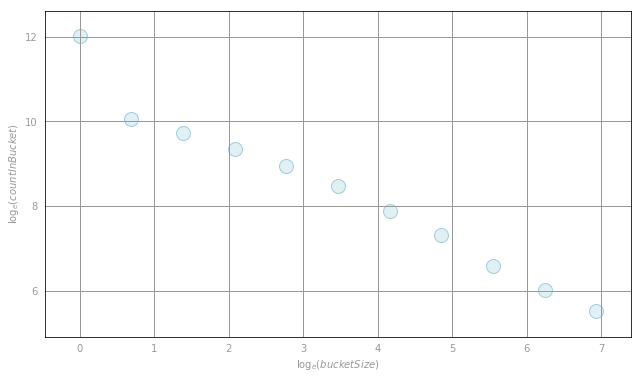

In [33]:
import matplotlib.pyplot as plt
% matplotlib inline

x, y = zip(*featCountsBuckets)
x, y = np.log(x), np.log(y)

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 10, 1), np.arange(4, 14, 2))
ax.set_xlabel(r'$\log_e(bucketSize)$'), ax.set_ylabel(r'$\log_e(countInBucket)$')
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
pass

#### **(3e) Atributos não observados **

#### Naturalmente precisaremos aplicar esse mesmo procedimento para as outras bases (validação e teste), porém nessas bases podem existir atributos não observados na base de treino.

#### Precisamos adaptar a função `oneHotEncoding` para ignorar os atributos que não existem no dicionário.

In [34]:
# EXERCICIO
def oneHotEncoding(rawFeats, OHEDict, numOHEFeats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.

    Note:
        If a (featureID, value) tuple doesn't have a corresponding key in OHEDict it should be
        ignored.

    Args:
        rawFeats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sampleOne)
        OHEDict (dict): A mapping of (featureID, value) to unique integer.
        numOHEFeats (int): The total number of unique OHE features (combinations of featureID and
            value).

    Returns:
        SparseVector: A SparseVector of length numOHEFeats with indicies equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    return SparseVector(numOHEFeats, [(OHEDict[x], 1.0) for x in rawFeats if x in OHEDict])

OHEValidationData = rawValidationData.map(lambda point: parseOHEPoint(point, ctrOHEDict, numCtrOHEFeats))
OHEValidationData.cache()
print (OHEValidationData.take(1))

[LabeledPoint(0.0, (234358,[2,8,15,21,45,49,50,52,61,96,135,160,164,671,1355,5140,5141,5142,117223,117226,117238,117242,117258,117261,117262,117267,117269,117284,117287,118378,119236,120375,122236,122237,122238,122239,122240,122241,170030],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [35]:
# TEST Handling unseen features (3e)
numNZVal = (OHEValidationData
            .map(lambda lp: len(lp.features.indices))
            .sum())
assert numNZVal == 367585, 'incorrect number of features'

### ** Part 4: Predição do CTR e avaliação da perda-log (logloss) **

#### ** (4a) Regressão Logística **

#### Um classificador que podemos utilizar nessa base de dados é a regressão logística, que nos dá a probabilidade de um evento de clique em banner ocorrer. Vamos utilizar a função  [LogisticRegressionWithSGD](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.classification.LogisticRegressionWithSGD) para treinar um modelo usando  `OHETrainData` com a configuração de parâmetros dada.  `LogisticRegressionWithSGD` retorna um [LogisticRegressionModel](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LogisticRegressionModel).  

#### Em seguida, imprima  `LogisticRegressionModel.weights` e `LogisticRegressionModel.intercept` para verificar o modelo gerado. 

In [36]:
from pyspark.mllib.classification import LogisticRegressionWithSGD

# fixed hyperparameters
numIters = 50
stepSize = 10.
regParam = 1e-6
regType = 'l2'
includeIntercept = True

In [37]:
# EXERCICIO
model0 = LogisticRegressionWithSGD.train(OHETrainData, numIters, stepSize, regParam=regParam, regType=regType, intercept=includeIntercept)
sortedWeights = sorted(model0.weights)
print (sortedWeights[:5], model0.intercept)

[-0.46297159426279577, -0.3904023018281789, -0.3871281985827924, -0.35815003494268316, -0.349632414954747] 0.5616041364601837


In [38]:
# TEST Logistic regression (4a)
assert np.allclose(model0.intercept,  0.5616041364601837), 'incorrect value for model0.intercept'
assert np.allclose(sortedWeights[0:5], [-0.46297159426279577, -0.39040230182817892, -0.3871281985827924, -0.35815003494268316, -0.34963241495474701]), 'incorrect value for model0.weights'

#### ** (4b) Log loss **

#### Uma forma de avaliar um classificador binário é através do log-loss, definido como: $$  \begin{align} \scriptsize \ell_{log}(p, y) = \begin{cases} -\log (p) & \text{if } y = 1 \\\ -\log(1-p) & \text{if } y = 0 \end{cases} \end{align} $$ onde $ \scriptsize p$ é uma probabilidade entre 0 e 1 e  $ \scriptsize y$ é o rótulo binário (0 ou 1). Log loss é um critério de avaliação muito utilizado quando deseja-se predizer eventos raros. Escreva uma função para calcular o log-loss, e avalie algumas entradas de amostra.

In [39]:
# EXERCICIO
import numpy as np

def computeLogLoss(p, y):
    """Calculates the value of log loss for a given probabilty and label.

    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon = 1e-11) from it.

    Args:
        p (float): A probabilty between 0 and 1.
        y (int): A label.  Takes on the values 0 and 1.

    Returns:
        float: The log loss value.
    """
    if p == 0.0:
        p += 1e-11
    elif p == 1.0:
        p -= 1e-11
    
    return -(y * np.log(p) + (1.0 - y) * np.log(1- p))

print (computeLogLoss(.5, 1))
print( computeLogLoss(.5, 0))
print (computeLogLoss(.99, 1))
print (computeLogLoss(.99, 0))
print (computeLogLoss(.01, 1))
print (computeLogLoss(.01, 0))
print (computeLogLoss(0, 1))
print (computeLogLoss(1, 1))
print (computeLogLoss(1, 0))

0.6931471805599453
0.6931471805599453
0.01005033585350145
4.605170185988091
4.605170185988091
0.01005033585350145
25.328436022934504
1.000000082745371e-11
25.328435940194137


In [40]:
# TEST Log loss (4b)
assert np.allclose([computeLogLoss(.5, 1), computeLogLoss(.01, 0), computeLogLoss(.01, 1)], [0.69314718056, 0.0100503358535, 4.60517018599]), 'computeLogLoss is not correct'
assert np.allclose([computeLogLoss(0, 1), computeLogLoss(1, 1), computeLogLoss(1, 0)], [25.3284360229, 1.00000008275e-11, 25.3284360229]), 'computeLogLoss needs to bound p away from 0 and 1 by epsilon'

#### ** (4c)  Baseline log loss **

#### Agora, vamos utilizar a função da Parte (4b) para calcular um baseline da métrica de log-loss na nossa base de treino. Uma forma de calcular um baseline é predizer sempre a média dos rótulos observados. Primeiro calcule a média dos rótulos da base e, em seguida, calcule o log-loss médio para a base de treino.

In [41]:
# EXERCICIO
# Note that our dataset has a very high click-through rate by design
# In practice click-through rate can be one to two orders of magnitude lower
classOneFracTrain = OHETrainData.map(lambda lp: lp.label).mean()
print (classOneFracTrain)

logLossTrBase = OHETrainData.map(lambda lp: computeLogLoss(classOneFracTrain, lp.label)).mean()
print ('Baseline Train Logloss = {0:.3f}\n'.format(logLossTrBase))

0.2271245299988764
Baseline Train Logloss = 0.536



In [42]:
# TEST Baseline log loss (4c)
assert np.allclose(classOneFracTrain, 0.2271245299988764), 'incorrect value for classOneFracTrain'
assert np.allclose(logLossTrBase, 0.535778466496), 'incorrect value for logLossTrBase'

#### ** (4d) Probabilidade da Predição **

#### O modelo gerado na Parte (4a) possui um método chamado `predict`, porém esse método retorna apenas 0's e 1's. Para calcular a probabilidade de um evento, vamos criar uma função `getP` que recebe como parâmetro o ponto x, o conjunto de pesos `w` e o `intercept`.

#### Calcule o modelo de regressão linear nesse ponto x e aplique a  [função sigmoidal](http://en.wikipedia.org/wiki/Sigmoid_function) $ \scriptsize \sigma(t) = (1+ e^{-t})^{-1} $ para retornar a probabilidade da predição do objeto x.



In [ ]:
# EXERCICIO
from math import exp #  exp(-t) = e^-t

def getP(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.

    Note:
        We'll bound our raw prediction between 20 and -20 for numerical purposes.

    Args:
        x (SparseVector): A vector with values of 1.0 for features that exist in this
            observation and 0.0 otherwise.
        w (DenseVector): A vector of weights (betas) for the model.
        intercept (float): The model's intercept.

    Returns:
        float: A probability between 0 and 1.
    """
    # calculate rawPrediction = w.x + intercept
    rawPrediction = <COMPLETAR>

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    
    # calculate (1+e^-rawPrediction)^-1
    return <COMPLETAR>

trainingPredictions = OHETrainData.<COMPLETAR>

print (trainingPredictions.take(5))

In [ ]:
# TEST Predicted probability (4d)
assert np.allclose(trainingPredictions.sum(), 18198.8525175), 'incorrect value for trainingPredictions'

#### ** (4e) Avalie o modelo **

#### Finalmente, crie uma função `evaluateResults` que calcula o log-loss médio do modelo em uma base de dados. Em seguida, execute essa função na nossa base de treino.

In [ ]:
# EXERCICIO
def evaluateResults(model, data):
    """Calculates the log loss for the data given the model.

    Args:
        model (LogisticRegressionModel): A trained logistic regression model.
        data (RDD of LabeledPoint): Labels and features for each observation.

    Returns:
        float: Log loss for the data.
    """
    return (data
            .<COMPLETAR>
            .<COMPLETAR>
            .<COMPLETAR>
            )

logLossTrLR0 = evaluateResults(model0, OHETrainData)
print ('OHE Features Train Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'.format(logLossTrBase, logLossTrLR0))

In [ ]:
# TEST Evaluate the model (4e)
assert np.allclose(logLossTrLR0, 0.45704573867), 'incorrect value for logLossTrLR0'

#### ** (4f) log-loss da validação **

#### Agora aplique o modelo na nossa base de validação e calcule o log-loss médio, compare com o nosso baseline.

In [ ]:
# EXERCICIO
logLossValBase = OHEValidationData.<COMPLETAR>

logLossValLR0 = evaluateResults(model0, OHEValidationData)
print ('OHE Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'.format(logLossValBase, logLossValLR0))

In [ ]:
# TEST Validation log loss (4f)
assert np.allclose(logLossValBase, 0.526558409461), 'incorrect value for logLossValBase'
assert np.allclose(logLossValLR0, 0.458434994198), 'incorrect value for logLossValLR0'

#### **Visualização 2: Curva ROC  **

#### A curva ROC nos mostra o custo-benefício entre a taxa de falso positivo e a taxa de verdadeiro positivo, conforme diminuimos o limiar de predição. Um modelo aleatório é representado por uma linha pontilhada. Idealmente nosso modelo deve formar uma curva acima dessa linha.

In [ ]:
labelsAndScores = OHEValidationData.map(lambda lp:
                                            (lp.label, getP(lp.features, model0.weights, model0.intercept)))
labelsAndWeights = labelsAndScores.collect()
labelsAndWeights.sort(key=lambda kv: kv[1], reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model
pass